In [33]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import timeit 
import torch.nn.functional as F
from tqdm import tqdm
import cv2

In [34]:
#!pip install sporco
from sporco import array,plot,util

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load alaska postack image**

(640, 384)
the shape is:  (640, 384)


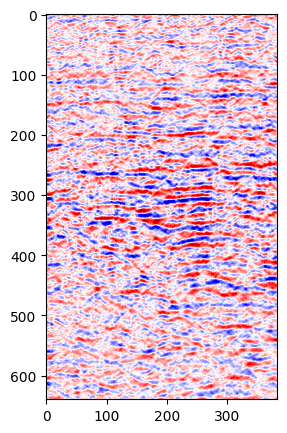

In [52]:
Data = np.load('datasets/alaska_poststack_exp2.npy')
Data = (Data - np.min(Data))/(np.max(Data) - np.min(Data))
#Data +=1 
#Data /=2

TestData = Data.copy()
print(TestData.shape)
#TestData = TestData[:608,:368]
plt.figure(figsize=(7,5))
plt.imshow(TestData,cmap='seismic')
#plt.colorbar(orientation='horizontal')

print('the shape is: ', TestData.shape)

In [37]:
singleffid = TestData.copy()
blksz = (128,128)
stpsz = (32,32)
blcks_corrupt = array.extract_blocks(singleffid, blksz, stpsz)
blcks_non_corrupt = array.extract_blocks(TestData, blksz, stpsz)

In [38]:
subblcks_corrupt = blcks_corrupt.transpose(2,0,1)
subblcks_non_corrupt = blcks_non_corrupt.transpose(2,0,1)
subblcks_non_corrupt = torch.from_numpy(subblcks_non_corrupt).unsqueeze(1)
subblcks_corrupt = torch.from_numpy(subblcks_corrupt).unsqueeze(1)

**Import model and load weights**

In [39]:
from models.Attention_unet import AttU_Net

In [40]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('checkpoints/att_u_fine.pt'))

<All keys matched successfully>

In [41]:
subblcks_corrupt.shape

torch.Size([153, 1, 128, 128])

**EXP 1 : RECONSTRUCTION ALASKA POSTSTACK IMAGE**

In [42]:
data_loader = torch.utils.data.DataLoader(subblcks_corrupt, batch_size=40)

In [43]:
denoised_tensor_list = []
for batch in tqdm(data_loader):
    with torch.no_grad():
        denoised_batch = model(batch.to(device))
        denoised_tensor_list.append(denoised_batch.cpu())
recov_blcks = torch.cat(denoised_tensor_list, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


In [44]:
recov_blcks = recov_blcks.cpu().numpy().transpose(0,2,3,1)
subblcks_corrupt = subblcks_corrupt.numpy().transpose(0,2,3,1)
subblcks_non_corrupt = subblcks_non_corrupt.numpy().transpose(0,2,3,1)

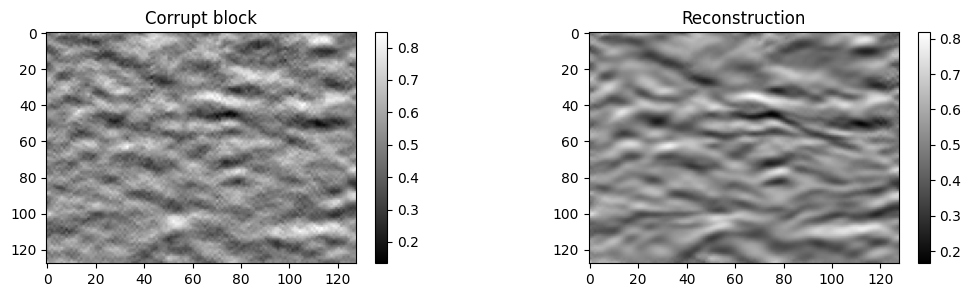

In [45]:
kk =100
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(subblcks_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), #plt.clim([0.5,0.64])
plt.colorbar()

plt.title("Corrupt block")

plt.subplot(122)
plt.imshow(recov_blcks[kk,:,:,0],aspect='auto',cmap='gray'), 
plt.colorbar()
plt.title("Reconstruction")


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [46]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [47]:
start = timeit.default_timer()
#imgd_median = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)
print("creating image from patching, time is:",
              timeit.default_timer() - start)

creating image from patching, time is: 5.792063299999995


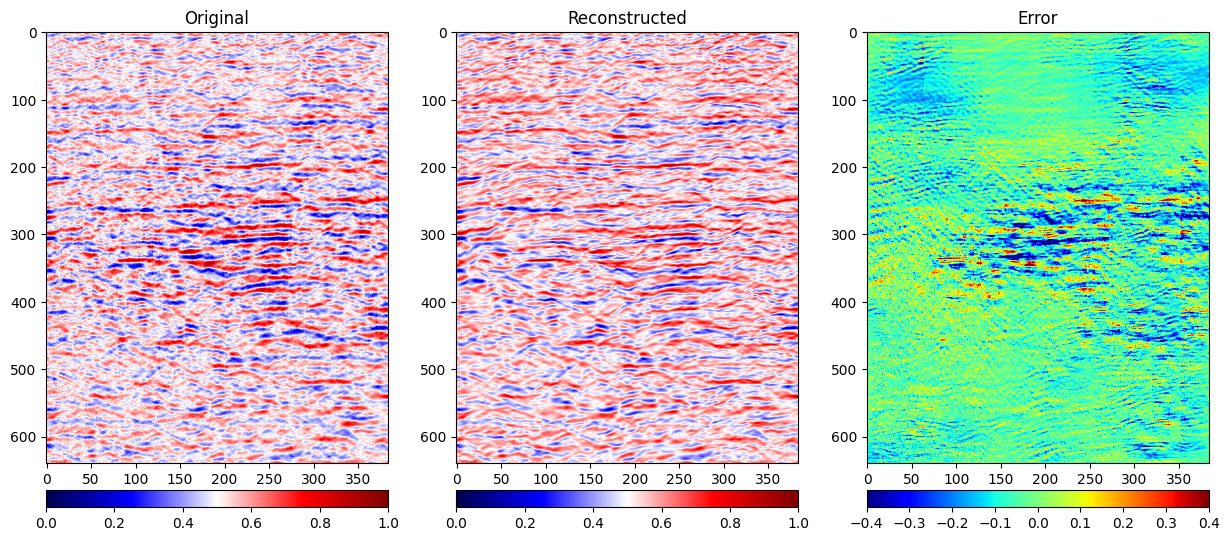

In [54]:
plt.figure(figsize=(15,7))

err = TestData-imgd_median
err /= np.max(np.abs(err))

plt.subplot(131)
plt.imshow(TestData,aspect='auto',cmap='seismic')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median,aspect='auto',cmap='seismic'), plt.clim([0,1])
plt.title('Reconstructed')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(133)
plt.imshow(err,aspect='auto',cmap='jet'),
plt.clim([-.4,.4])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

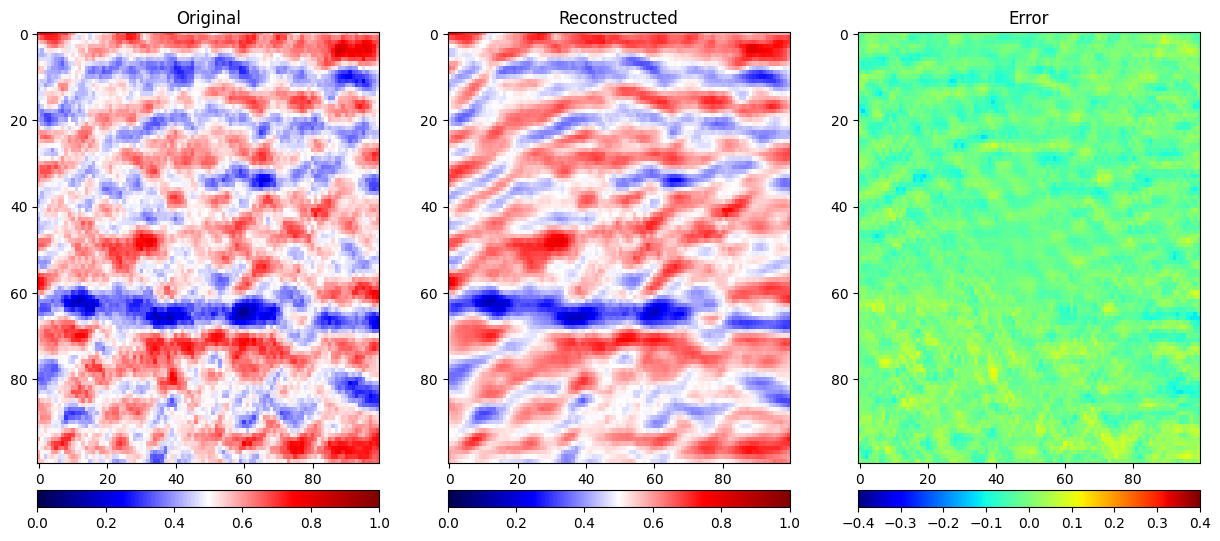

In [53]:
err_section = TestData[200:300,50:150]-imgd_median[200:300,50:150]

plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(TestData[200:300,50:150],aspect='auto',cmap='seismic')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[200:300,50:150],aspect='auto',cmap='seismic'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(err_section,aspect='auto',cmap='jet'),
plt.clim([-.4,.4])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

**Fast Noise variance Estimation**

In [51]:
import math
def estimate_noise(I):

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  I= torch.from_numpy(I).float()
  M=np.array(M)
  M=torch.from_numpy(M).float()
  imgFiltered = F.conv2d(I.unsqueeze(0).unsqueeze(0), M.unsqueeze(0).unsqueeze(0), padding=1)
  x=imgFiltered.numpy()
  sigma = np.sum(np.sum(np.absolute(x)))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return sigma
print("Noisy image:",estimate_noise(TestData))
print("Denoised image:",estimate_noise(imgd_median))

Noisy image: 0.01659721862055524
Denoised image: 0.004843377726034104
